In [6]:
import numpy as np
import matplotlib.pyplot as plt
import helpers.cusplot as cplt

## constants (SI)

In [12]:
## kicker
brho = 1.23 
lgap = 0.1
hap = 0.1 # horizontal aperture
kick_l = 0.5
N = 20
u0 = 4*np.pi*1e-7

thet_kick = 0.02
l = 3 # dist. kicker-septum

B = brho*thet_kick/kick_l
NI = B/u0*lgap

## charge distribution
sigma = 0.015
delta_x_max = 0.01

## septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

### inductance (N turns)

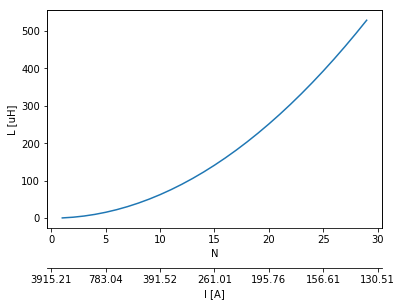

In [21]:
# induct. vs. turns vs. current

# turns
N_arr = np.arange(1,30)
I_arr = NI/N_arr
# inductance in uH
L_arr = u0*N_arr**2*hap/lgap*kick_l*1e6
ax = plt.gca()
ax.plot(N_arr,L_arr)
ax.set_ylabel('L [uH]')
ax.set_xlabel('N')

def N_to_I(N):
    if N != 0:
        I = NI/N
    else:
        I = NI
    return round(I,2)

cplt.add_axis(ax, 'x', N_to_I, 'I [A]')
    

plt.show()

### septum irradiation

In [15]:
# numeric integration of current fraction 
# incident on septum
d = {}

for delta_x in np.linspace(0,delta_x_max,10):
    I = 0
    for step in np.linspace(2*sigma-w/2, 2*sigma + w/2,10):
        I += np.exp(-(step-delta_x)**2/(2*sigma**2))*w/10
    
    I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I
    
    d[delta_x] = I_norm

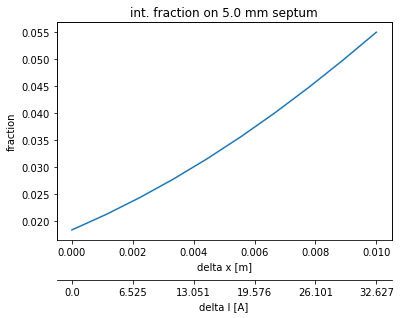

In [22]:
ax = plt.gca()

ax.plot(*zip(*sorted(d.items())))
ax.set_xlabel('delta x [m]')
ax.set_ylabel('fraction')

ax.set_title('int. fraction on {} mm septum'.format(w*1e3))

#convert spat. to curr_off
def dx_to_dI(dx):
    dThet = dx/l
    dI = brho*lgap/(u0*kick_l*N)*dThet
    return round(dI,3)

cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A]' )

plt.show()